# Librairies

In [2]:
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pylab as plt

# 1. Load Data 

In [2]:
# Combine data from 2019 - 2024
l_df = []
for year in range(2019, 2024):
    # Load the corresponding file
    df = pd.read_csv(f'raw/comptage_trafic_{year}.csv', delimiter=';')
    df['year'] = year
    l_df.append(df)
df = pd.concat(l_df)
# Memory
l_df = None

# 1. Referential

In [3]:
ref = gpd.read_file('raw/pc_capte_p.geojson')

In [4]:
# Join both dataframe

jf = df.rename(columns = {'IDENT' : 'ident'}).set_index('ident').join(
    ref.set_index('ident'),
    how = 'inner'
)

In [5]:
jf.columns

Index(['HPM_VAL', 'HPS_VAL', 'MJO_VAL', 'HPM_%', 'HPS_%', 'MJO_%', 'PL_VAL',
       'PL_%', 'VIT_VAL', 'VIT_EVO', 'COMMENT', 'NOM_VOIE', 'SENS_CIR',
       'V85_VL', 'V85_PL', 'year', 'geo_point_2d', 'gid', 'type', 'zone',
       'comptage_5m', 'cdate', 'mdate', 'commune', 'code_commune', 'geometry'],
      dtype='object')

In [6]:
jf[[  'MJO_VAL', 
      'MJO_%', 
      'PL_VAL',
      'PL_%', 
      'VIT_VAL', 
      'VIT_EVO', 
      'V85_VL', 
      'V85_PL',]]

,MJO_VAL,MJO_%,PL_VAL,PL_%,VIT_VAL,VIT_EVO,V85_VL,V85_PL
ident,,,,,,,,
Z05AS,4434.0,2.0,538.0,7.0,44.4500,-0.05,NaN,NaN
Z05BE,8069.0,NaN,801.0,NaN,38.1333,NaN,NaN,NaN
Z05BS,8942.0,NaN,850.0,NaN,32.4000,NaN,NaN,NaN
Z06AS,7100.0,-7.0,213.0,1.0,40.4000,-0.04,NaN,NaN
Z7CS,5924.0,NaN,340.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
Z8CT9,6878.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN
Z9CT1,15052.0,-5.5,NaN,NaN,NaN,NaN,NaN,NaN
Z9CT12,7709.0,0.4,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# The "percentage" metric can be <0 so we don't use it
jf['MJO_%'].describe()

count    2094.000000
mean       -1.922875
std        10.454153
min      -100.000000
25%        -7.000000
50%        -2.000000
75%         2.700000
max        89.000000
Name: MJO_%, dtype: float64

In [8]:
# Set to nan negative %
jf.loc[jf['MJO_%'] < 0, 'MJO_%'] = np.nan
# Set to nan 0 flow values
jf.loc[jf['MJO_VAL'] <= 0, 'MJO_VAL'] = np.nan

In [9]:
# Speed measurements are NA
jf.isna().all()

HPM_VAL         False
HPS_VAL         False
MJO_VAL         False
HPM_%           False
HPS_%           False
MJO_%           False
PL_VAL          False
PL_%            False
VIT_VAL         False
VIT_EVO         False
COMMENT         False
NOM_VOIE        False
SENS_CIR        False
V85_VL           True
V85_PL           True
year            False
geo_point_2d    False
gid             False
type            False
zone            False
comptage_5m     False
cdate           False
mdate           False
commune         False
code_commune    False
geometry        False
dtype: bool

In [10]:
jf.rename(columns = {
    'MJO_VAL' : 'AAWT',  
     'PL_VAL': 'TR_AAWT',
       'VIT_VAL' : 'savg', 
       'NOM_VOIE' : 'raw_name',
       'SENS_CIR' : 'raw_direction',
       'type':'raw_techno'
       # Only NaNs
      #  'V85_VL' : 's85', 
      #  'V85_PL' : 'TR_s85',
}, inplace=True)

In [11]:
jf.dropna(subset =['AAWT'], inplace=True)

In [12]:
jf = jf[['AAWT', 'TR_AAWT', 'savg', 'year', 'geometry', 'raw_name', 'raw_direction', 'raw_techno']]

In [13]:
jf = gpd.GeoDataFrame(jf, geometry = 'geometry', crs = 'epsg:4326')

In [14]:
jf.head()

,AAWT,TR_AAWT,savg,year,geometry,raw_name,raw_direction,raw_techno
ident,,,,,,,,
Z05AS,4434.0,538.0,44.4500,2019,POINT (-0.53583 44.81479),Bègles Quai Wilson,Sens Sortant,SIREDO
Z05BE,8069.0,801.0,38.1333,2019,POINT (-0.53191 44.82091),Bordeaux Quai Souys (près rue Bergès),Sens Entrant,SIREDO
Z05BS,8942.0,850.0,32.4000,2019,POINT (-0.53202 44.8209),Bordeaux Quai Souys (près rue Bergès),Sens Sortant,SIREDO
Z06AS,7100.0,213.0,40.4000,2019,POINT (-0.62292 44.83862),Mérignac 44 av. de Mérignac,Sens Sortant,SIREDO
Z7CS,5924.0,340.0,NaN,2019,POINT (-0.80098 44.83419),NaN,Sens Sortant,SIREDO


(-0.879077911376953, -0.4395563310775237, 44.71556948693501, 44.96491938767992)

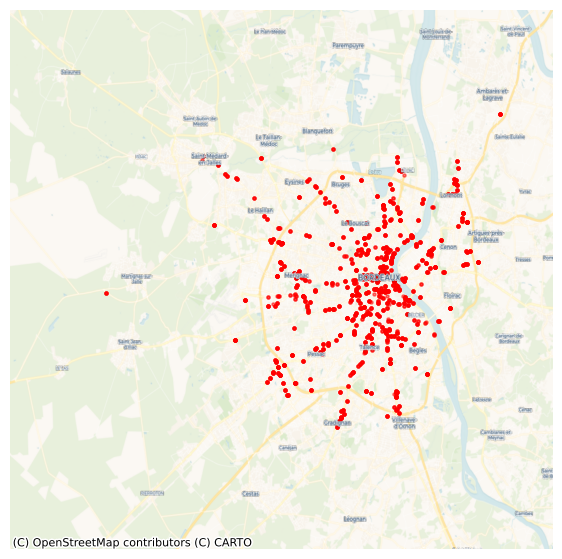

In [15]:
# Plot sensors
#plt.figure(figsize = (10,10), dpi = 300)
import contextily as cx
fig, ax = plt.subplots(figsize = (7,7), dpi = 100)
jf.plot(ax=ax, color = 'r', markersize = 5, alpha = .5)
# Add context in backround
cx.add_basemap(ax, crs = jf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = jf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

# 2. Load other Data (not used)

In [16]:
# Other source : temporary counts
gdf = gpd.read_file('raw/pc_capte_ponct_p.geojson')

In [17]:
gdf.annee.unique()

array(['2022', '2023', '2024', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021'], dtype=object)

In [18]:
gdf.annee = gdf.annee.astype('int')

In [19]:
gdf.sens_orientation.unique()

array(['1', '2', None], dtype=object)

In [20]:
gdf['type'].unique()

array(['COMPTAGE_ROUTIER'], dtype=object)

In [21]:
gdf.orientation.unique()

array(['NORD', 'SUD', 'EST', 'OUEST', 'SUD_OUEST', 'NORD_EST', 'SUD_EST',
       'NORD_OUEST', None], dtype=object)

In [22]:
gdf.columns

Index(['geo_point_2d', 'gid', 'num_materiel', 'type', 'insee',
       'sens_orientation', 'orientation', 'tmjo_tv', 'tmjo_vl', 'tmjo_pl',
       'hpm_tv', 'hps_tv', 'v85_vl', 'v85_pl', 'annee', 'semaine',
       'orientation_av_2021', 'cdate', 'mdate', 'geometry'],
      dtype='object')

In [23]:
# Understanding column values
abs(gdf['tmjo_tv'] - (gdf['tmjo_vl'] + gdf['tmjo_pl'])).describe()

count     5830.000000
mean         6.333791
std        247.370746
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      11400.000000
dtype: float64

In [24]:
gdf.loc[abs(gdf['tmjo_tv'] - (gdf['tmjo_vl'] + gdf['tmjo_pl'])) > 1000]
# Sometimes tmjo_vl is at 0 whereas the tmjo_vl value is big

,geo_point_2d,gid,num_materiel,type,insee,sens_orientation,orientation,tmjo_tv,tmjo_vl,tmjo_pl,hpm_tv,hps_tv,v85_vl,v85_pl,annee,semaine,orientation_av_2021,cdate,mdate,geometry
2097,"{ ""lon"": -0.63484189999999996, ""lat"": 44.78966...",339,None,COMPTAGE_ROUTIER,33318,None,None,10732,0.0,0.0,918.0,939.0,NaN,NaN,2015,comptage du 30/01/2015 au 05/02/2015,Vers la Rocade,2023-12-15 16:00:22+00:00,2024-02-14 14:12:17+00:00,POINT (-0.63484 44.78966)
2098,"{ ""lon"": -0.634876, ""lat"": 44.789526899999998 }",340,None,COMPTAGE_ROUTIER,33318,None,None,10455,0.0,0.0,738.0,924.0,NaN,NaN,2015,comptage du 30/01/2015 au 05/02/2015,Vers la rue Edouard Herriot,2023-12-15 16:00:22+00:00,2024-02-14 14:12:17+00:00,POINT (-0.63488 44.78953)
2119,"{ ""lon"": -0.56648100000000001, ""lat"": 44.78638...",411,None,COMPTAGE_ROUTIER,33550,None,None,11400,0.0,0.0,NaN,NaN,NaN,NaN,2015,comptage du 09/06/2015 au 15/06/2015,Vers la rue Danielle Mitterrand,2023-12-15 16:00:22+00:00,2024-02-14 14:12:17+00:00,POINT (-0.56648 44.78639)
3676,"{ ""lon"": -0.56967789999999996, ""lat"": 44.83290...",1047,None,COMPTAGE_ROUTIER,33063,None,None,1157,0.0,0.0,68.0,102.0,NaN,NaN,2017,comptage du 20/03/2017 au 26/03/2017,Sens unique vers la rue Permentade,2023-12-15 16:00:23+00:00,2024-02-14 14:12:17+00:00,POINT (-0.56968 44.8329)


In [25]:
gdf.rename(columns = {
    'tmjo_tv' : 'AAWT',  
     'tmjo_pl': 'TR_AAWT',
       'v85_vl' : 's85',
       'v85_pl':'TR_s85' ,
        'annee':'year'
}, inplace=True)

In [26]:
gdf.dropna(subset = ['AAWT'], inplace=True)

# Map matching with OSM

In [27]:
jf

,AAWT,TR_AAWT,savg,year,geometry,raw_name,raw_direction,raw_techno
ident,,,,,,,,
Z05AS,4434.0,538.0,44.4500,2019,POINT (-0.53583 44.81479),Bègles Quai Wilson,Sens Sortant,SIREDO
Z05BE,8069.0,801.0,38.1333,2019,POINT (-0.53191 44.82091),Bordeaux Quai Souys (près rue Bergès),Sens Entrant,SIREDO
Z05BS,8942.0,850.0,32.4000,2019,POINT (-0.53202 44.8209),Bordeaux Quai Souys (près rue Bergès),Sens Sortant,SIREDO
Z06AS,7100.0,213.0,40.4000,2019,POINT (-0.62292 44.83862),Mérignac 44 av. de Mérignac,Sens Sortant,SIREDO
Z7CS,5924.0,340.0,NaN,2019,POINT (-0.80098 44.83419),NaN,Sens Sortant,SIREDO
...,...,...,...,...,...,...,...,...
Z8CT9,6878.0,NaN,NaN,2023,POINT (-0.53781 44.85367),Cenon Av. Jean Jaurès,Sens Sortant,BOUCLE
Z9CT1,15052.0,NaN,NaN,2023,POINT (-0.59893 44.83567),Bordeaux Blvd Gautier après Arès,Boulevards Nord > Sud,BOUCLE
Z9CT12,7709.0,NaN,NaN,2023,POINT (-0.60174 44.83323),Bordeaux Blvd Geoges Pompidou / Doumerc,Sens Entrant,BOUCLE


In [28]:
jf.geometry.unique().size

548

In [29]:
jf.index.drop_duplicates().size

548

In [30]:
gdf = jf[~jf.index.duplicated()]
# Create a subset without duplicated sensors

In [31]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import points_matching

In [32]:
gdf = points_matching(gdf)

City downloaded


 93%|█████████▎| 512/548 [00:03<00:00, 126.84it/s]

Value Error - No roads found nearby current index


100%|██████████| 548/548 [00:03<00:00, 142.75it/s]

We failed to match 1 sensors
...on a total of 548 sensors


In [33]:
gdf[['raw_name', 'osm_name']].dropna().drop_duplicates()[:30]

,raw_name,osm_name
ident,,
Z05AS,Bègles Quai Wilson,Quai du Président Wilson
Z05BE,Bordeaux Quai Souys (près rue Bergès),Quai de la Souys
Z06AS,Mérignac 44 av. de Mérignac,Avenue de Mérignac
Z09AE,Mérignac VDO,Avenue François Mitterrand
Z10BE,Bordeaux rue Bethmann Bx II,Rue de Bethmann
Z12AS,Bègles 99 cours Victor Hugo,Cours Victor Hugo
Z14BE,Bordeaux Bld A.Daney Latule R.Maran,Boulevard Alfred Daney
Z14BS,Bordeaux Bld A.Daney Latule R.Maran,Boulevard Alfred Daney
Z16AE,Pessac 190 av. Jean Jaurès,Avenue Jean Jaurès


In [34]:
jf = jf.join(gdf[['osm_name', 'osm_type', 'osm_lanes', 'osm_distance', 'osm_oneway', 'osmid']], how = 'inner')

# Final Saving

In [35]:
jf.head()

,AAWT,TR_AAWT,savg,year,geometry,raw_name,raw_direction,raw_techno,osm_name,osm_type,osm_lanes,osm_distance,osm_oneway,osmid
ident,,,,,,,,,,,,,,
Z05AS,4434.0,538.0,44.4500,2019,POINT (-0.53583 44.81479),Bègles Quai Wilson,Sens Sortant,SIREDO,Quai du Président Wilson,tertiary,2.0,0.987207,NaN,5.897011e+08
Z05BE,8069.0,801.0,38.1333,2019,POINT (-0.53191 44.82091),Bordeaux Quai Souys (près rue Bergès),Sens Entrant,SIREDO,Quai de la Souys,secondary,2.0,0.362988,True,6.772702e+08
Z05BS,8942.0,850.0,32.4000,2019,POINT (-0.53202 44.8209),Bordeaux Quai Souys (près rue Bergès),Sens Sortant,SIREDO,Quai de la Souys,secondary,1.0,1.152661,True,1.302658e+09
Z06AS,7100.0,213.0,40.4000,2019,POINT (-0.62292 44.83862),Mérignac 44 av. de Mérignac,Sens Sortant,SIREDO,Avenue de Mérignac,secondary,2.0,1.632515,NaN,2.212514e+08
Z7CS,5924.0,340.0,NaN,2019,POINT (-0.80098 44.83419),NaN,Sens Sortant,SIREDO,Avenue du Bassin d'Arcachon,secondary,2.0,1.669094,False,2.583346e+07


In [ ]:
jf['raw_oneway'] = True

In [36]:
# Saving
for year in range(2019, 2024):
    # Extract corresponding year
    sub = jf[jf.year == year]
    print(year, sub.shape[0])
    sub[[
        'AAWT', 'TR_AAWT', 'savg', 'geometry', 
    #    'source',
    #     's85',
    #    'TR_s85', 
       'raw_name', 'raw_oneway', 'raw_direction', 'raw_techno', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osmid'
        ]].to_file(f'treated/Bordeaux_AAWT_{year}.geojson', index=False)

2019 469
2020 504
2021 438
2022 408
2023 345
